<a href="https://www.kaggle.com/code/oscarfraley/xfantasy?scriptVersionId=158178223" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import seaborn as sns

# Data Extraction Class

- All data is aquired from https://github.com/vaastav/Fantasy-Premier-League.
- Raw data is manipulated into a dataframe whereby each index is a player from a specific gameweek and features contain averages of their form (xG, xA ...), information on the particular fixture (opposition average xGC form, home/away) as well as their true gameweek points scored (target). 

In [2]:
class xFormBase:
    def __init__(self, gw, season, form_range=4):
        self.gw = gw
        self.range = form_range
        self.season = season
        self.form_data = self.get_form_data()

    # function to extract form data.
    def get_form_data(self):
        data = pd.DataFrame()
        for i in range(self.range):
            url = self.get_url(i+1)
            temp = pd.read_csv(url).drop(['kickoff_time', 'was_home', 'expected_goals_conceded', 'starts'], axis=1)
            temp = temp.groupby(['name', 'position', 'team']).mean()
            data = pd.concat([data, temp])
        data = data.groupby(['name', 'position', 'team']).mean().reset_index(['position'])
        return data

    def get_url(self, lag):
        return 'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/20' \
               + str(self.season) + '-' + str(self.season + 1) + '/gws/gw' + str(self.gw - lag) + '.csv'
    
    #function to calculate total xG conceded by each team in particuar gameweek.
    def calculate_team_defence(self): 
        data = []
        for n in range(self.range):
            temp = pd.read_csv(self.get_url(n+1))
            temp = temp.loc[temp.minutes == 90][['team', 'expected_goals_conceded']]
            data.append(temp.groupby('team').mean()) 
        return pd.concat([data[i] for i in range(self.range)]).groupby('team').mean().expected_goals_conceded
            
    # function to calculate total xG generated by each team in a particular gameweek.
    def calculate_team_attack(self):
        data = []
        for n in range(self.range):
            temp = pd.read_csv(self.get_url(n+1))
            temp = temp[['name','team', 'expected_goals']].groupby(['name', 'team']).mean().groupby(['team']).sum()
            data.append(temp)   
        return pd.concat([data[i] for i in range(self.range)]).groupby('team').mean().expected_goals


class xFormTrain(xFormBase):
    def __init__(self, gw, season, form_range=4):
        super().__init__(gw, season, form_range=4)
        self.fixture_data = self.get_fixture_data()
        self.df = self.create_final_df()
        
    # function that extracts data for the upcoming fixture.
    def get_fixture_data(self):
        url = self.get_url(0)
        data = pd.read_csv(url)
        data = data[['name', 'team', 'was_home', 'total_points', 'opponent_team']]
        data = data.rename(columns={'total_points': 'points_scored'})
        team_defence = self.calculate_team_defence()
        team_attack = self.calculate_team_attack()
        data['opponent_defence'] = data.opponent_team.apply(lambda x: team_defence[x-1])
        data['opponent_attack'] = data.opponent_team.apply(lambda x: team_attack[x-1])
        data['team_defence'] = data.team.apply(lambda x: team_defence[x])
        data = data.drop(['opponent_team'], axis=1).groupby(['name', 'team']).mean()
        data = data[data['was_home'] % 1 == 0] # Delete double gw's where players play at home and away.
        return data
    
    # function to join form data to fixture data
    def create_final_df(self):
        df = self.form_data.join(self.fixture_data, on=['name', 'team'])
        df_refined = df[(df.points_scored.isnull() == False) & (df.minutes > 0)] 
        return df_refined

                            
class xFormFuture(xFormBase):
    def __init__(self, gw, look_ahead=0, form_range=4, season=23):
        super().__init__(gw, season, form_range)
        self.look_ahead = look_ahead
        self.df = self.get_fixture_data()

    def get_fixture_data(self):
        fixtures = pd.read_csv('/kaggle/input/prem-fixtures/fixtures.csv') \
            [['Round Number', 'Home Team', 'Away Team']] \
            .replace({'Nottingham Forest': 'Forest'})

        fixtures = fixtures[(fixtures['Round Number'] == self.gw+self.look_ahead)]
        form = self.form_data.reset_index(['team']).replace({'Nott\'m Forest': 'Forest'})
        dictionary = {}
        for i, team in enumerate(form.team):
            if (fixtures['Home Team'] == team).any():
                home = 1
                oppo = fixtures[(fixtures['Home Team'] == team)]['Away Team'].item()
                dictionary[i] = []
                dictionary[i].append(home)
                dictionary[i].append(oppo)
            else:
                home = 0
                oppo = fixtures[(fixtures['Away Team'] == team)]['Home Team'].item()
                dictionary[i] = []
                dictionary[i].append(home)
                dictionary[i].append(oppo)
        form.set_index('team')
        df = pd.DataFrame(dictionary)
        df = df.transpose().set_index(form.index)
        df.columns = ['was_home', 'oppo']
        data = form.join(df, on=['name'])
        data = data.replace({'Forest': 'Nott\'m Forest'})
        team_defence = self.calculate_team_defence()
        team_attack = self.calculate_team_attack()
        data['opponent_defence'] = data.oppo.apply(lambda x: team_defence[x])
        data['opponent_attack'] = data.oppo.apply(lambda x: team_attack[x])
        data['team_defence'] = data.team.apply(lambda x: team_defence[x])
        data = data.drop(['oppo', 'team'], axis=1)
        data_ref = data[(data.was_home != 0.5)] 
        return data_ref

The two inherited classes differ by only a few functions. xFormTrain extracts the dataset to be used in training. xFormFixture extracts data for an up and coming gameweek in order to make prediction, the caveat being that the online dataset doesnt contain information about future matches.

# Create Dataset

Now we contruct the dataset by concatenating multiple instances of the data extraction class. This dataset contains players of ALL positions.

In [3]:
data = xFormTrain(gw=21, season=22, form_range=4).df
for i in range(17):
    data = pd.concat([data, xFormTrain(gw=22+i, season=22, form_range=4).df])
for i in range(16):
    data = pd.concat([data, xFormTrain(gw=5+i, season=23, form_range=4).df])

# Feature engineering

In [4]:
gk_features = ['minutes', 'bps', 'ict_index','saves','opponent_attack','team_defence','was_home']
def_features = ['minutes', 'bps', 'ict_index','opponent_attack','opponent_defence','expected_goals', 'expected_assists', 'team_defence','was_home']
att_features = ['value', 'transfers_balance', 'selected', 'minutes', 'bps', 'threat', 'creativity', 'influence', 'total_points', 'goals_scored', 'assists', 'bonus', 'opponent_defence', 'opponent_attack',  'expected_goals', 'expected_assists','was_home']

In [5]:
def position_dataset(position, data):
    if position == 'GK':
        pos_data = data.loc[data.position == position][gk_features+['points_scored']]
    elif position == 'DEF':
        pos_data = data.loc[data.position == position][def_features+['points_scored']]
    else:
        pos_data = data.loc[data.position == position][att_features+['points_scored']]
        pos_data = pos_data[pos_data['expected_goals'] > 0.05]
    pos_data = pos_data[pos_data.minutes > 45]
    pos_data = pos_data[pos_data.points_scored != 0]
    return pos_data

In [6]:
def pred_position_dataset(position, data):
    if position == 'GK':
        pos_data = data.loc[data.position == position][gk_features]
    elif position == 'DEF':
        pos_data = data.loc[data.position == position][def_features]
    else:
        pos_data = data.loc[data.position == position][att_features]
        pos_data = pos_data[(pos_data['expected_goals'] + pos_data['expected_assists'] > 0.05)]
    pos_data = pos_data[pos_data.minutes > 45]
    return pos_data

In [7]:
GK = position_dataset('GK', data)
DEF = position_dataset('DEF', data)
MID = position_dataset('MID', data)
FWD = position_dataset('FWD', data)

# Model Class

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.metrics import mean_absolute_error

Class that creates a dataframe based on the position specified as input. The class has functions to calculate the cross-val score of a particular regressor & transformer, to fit the model, and then to create predictions for upcoming gameweeks.

In [9]:
class ModelClass:
    def __init__(self, data):
        self.data = data
        self.pipe = None

    def _initialize_pipeline(self, regressor, transformer):
        pipe = Pipeline(steps=[('preprocessor',transformer),
                       ('regressor', regressor)]) 
        return pipe

    def cross_val_score(self, regressor, transformer):
        X = self.data.copy()
        y = X.pop('points_scored')
        pipe = self._initialize_pipeline(regressor, transformer)
        scores = -1 * cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_absolute_error')
        return scores.mean()
        
    def fit_pipe(self, regressor, transformer):
        self.pipe = self._initialize_pipeline(regressor, transformer)
        X = self.data.copy()
        y = X.pop('points_scored')
        self.pipe.fit(X, y)

    def predictions(self, position, gw):
        self.pred_data = xFormFuture(gw).df
        self.X_pred = pred_position_dataset(position, self.pred_data)
        pred = pd.DataFrame(self.pipe.predict(self.X_pred), index=self.X_pred.index, columns=['xP'])
        return pred.sort_values(by=['xP'],ascending=False)
    
    def future_predictions(self, position, gw, pred_range):
        predictions = []
        for i in range(pred_range):
            pred = xFormFuture(gw, look_ahead=i).df
            X_pred = pred_position_dataset(position, pred)
            predictions.append(pd.DataFrame(self.pipe.predict(X_pred), index=X_pred.index, columns=['xP_'+str(i+1)])) 
        future_predictions = pd.merge(predictions[0], predictions[1], on='name')
        for i in range(pred_range-2):
            future_predictions= future_predictions.merge(predictions[i+2], on='name')
        future_predictions['mean_value'] = future_predictions.mean(axis=1)
        future_predictions = future_predictions.sort_values(by='mean_value', ascending=False)       
        return future_predictions

# Model Eval

In [10]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [11]:
teams = ['Arsenal', 'Aston Villa','Bournemouth','Brentford', 
         'Brighton', 'Burnley', 'Chelsea','Crystal Palace',
         'Everton','Fulham','Liverpool','Luton', 'Man City',
         'Man Utd', 'Newcastle','Forest', 
         'Sheffield Utd','Spurs','West Ham', 'Wolves']

In [12]:
#regressors = [XGBRegressor(), LGBMRegressor()]
regressors = [Lasso(), Ridge()]
transformers = [StandardScaler(), PowerTransformer(), None]

In [13]:
best_score = 100
model = ModelClass(MID)
for regressor in regressors:
    for transformer in transformers:
        score = model.cross_val_score(regressor, transformer)
        if score < best_score:
            best_score = score
            model.fit_pipe(regressor, transformer)
            best_model = model
        print(f'Model: {regressor}, transformer: {transformer} got score: {score}')

Model: Lasso(), transformer: StandardScaler() got score: 2.532649264405536
Model: Lasso(), transformer: PowerTransformer() got score: 2.532649264405536
Model: Lasso(), transformer: None got score: 2.4058601553484626
Model: Ridge(), transformer: StandardScaler() got score: 2.365328656264494
Model: Ridge(), transformer: PowerTransformer() got score: 2.3731254663126267
Model: Ridge(), transformer: None got score: 2.3653461899260906


In [14]:
best_model.pipe

Pipeline(steps=[('preprocessor', StandardScaler()), ('regressor', Ridge())])

In [15]:
pred = best_model.predictions('MID', 21)

In [16]:
preds = best_model.future_predictions('MID', 21, 10)

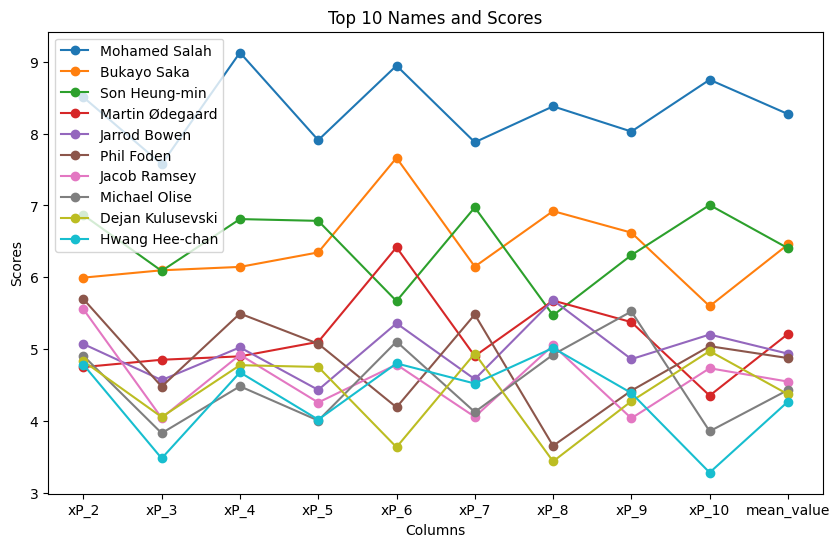

In [17]:
n=10
top_n = preds.head(n)

plt.figure(figsize=(10, 6))

for index, row in top_n.iterrows():
    # Extract column names and values dynamically
    columns = preds.columns[1:]  # Exclude the 'name' column
    values = row[1:]  # Exclude the 'name' value

    # Plot a line for each name
    plt.plot(columns, values, label=index, marker='o')


# Add labels and title
plt.xlabel('Columns')
plt.ylabel('Scores')
plt.title(f'Top {n} Names and Scores')
plt.legend()

# Show the plot
plt.show()


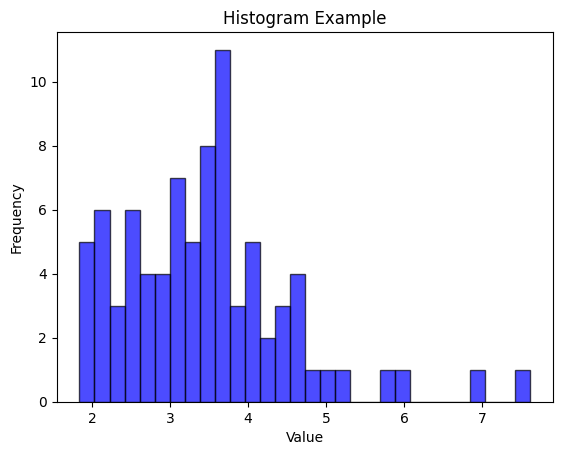

In [18]:
plt.hist(pred, bins=30, color='blue', alpha=0.7, edgecolor='black')

# Add labels and title
plt.title('Histogram Example')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [19]:
pred.head(15)

,xP
name,
Mohamed Salah,7.620632
Bukayo Saka,7.027606
Son Heung-min,6.074428
Martin Ødegaard,5.781674
Phil Foden,5.217627
Cole Palmer,5.043007
Bruno Borges Fernandes,4.834848
Marcus Rashford,4.684994
Gabriel Martinelli Silva,4.674900


In [20]:
best_model.X_pred.loc['Martin Ødegaard']

value                8.400000e+01
transfers_balance    1.926275e+04
selected             1.571400e+06
minutes              9.000000e+01
bps                  1.600000e+01
threat               2.800000e+01
creativity           5.602500e+01
influence            2.180000e+01
total_points         3.750000e+00
goals_scored         0.000000e+00
assists              2.500000e-01
bonus                7.500000e-01
opponent_defence     1.722500e+00
opponent_attack      1.337500e+00
expected_goals       1.700000e-01
expected_assists     3.850000e-01
was_home             1.000000e+00
Name: Martin Ødegaard, dtype: float64